# Introduction

In this project, you will build a neural network of your own design to evaluate the CIFAR-10 dataset.
Our target accuracy is 70%, but any accuracy over 50% is a great start.
Some of the benchmark results on CIFAR-10 include:

78.9% Accuracy | [Deep Belief Networks; Krizhevsky, 2010](https://www.cs.toronto.edu/~kriz/conv-cifar10-aug2010.pdf)

90.6% Accuracy | [Maxout Networks; Goodfellow et al., 2013](https://arxiv.org/pdf/1302.4389.pdf)

96.0% Accuracy | [Wide Residual Networks; Zagoruyko et al., 2016](https://arxiv.org/pdf/1605.07146.pdf)

99.0% Accuracy | [GPipe; Huang et al., 2018](https://arxiv.org/pdf/1811.06965.pdf)

98.5% Accuracy | [Rethinking Recurrent Neural Networks and other Improvements for ImageClassification; Nguyen et al., 2020](https://arxiv.org/pdf/2007.15161.pdf)

Research with this dataset is ongoing. Notably, many of these networks are quite large and quite expensive to train. 

## Imports

In [1]:
## This cell contains the essential imports you will need – DO NOT CHANGE THE CONTENTS! ##
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
import numpy as np

## Load the Dataset

Specify your transforms as a list first.
The transforms module is already loaded as `transforms`.

CIFAR-10 is fortunately included in the torchvision module.
Then, you can create your dataset using the `CIFAR10` object from `torchvision.datasets` ([the documentation is available here](https://pytorch.org/docs/stable/torchvision/datasets.html#cifar)).
Make sure to specify `download=True`! 

Once your dataset is created, you'll also need to define a `DataLoader` from the `torch.utils.data` module for both the train and the test set.

In [3]:
# Define transforms
# Define transforms for training set (with data augmentation to improve generalization)
transform_train = transforms.Compose([
    transforms.RandomHorizontalFlip(), # flip the image horizontally at random
    transforms.RandomCrop(32, padding=4), # crop the image to 32x32 with padding of 4
    transforms.ToTensor(), # convert the image to a PyTorch tensor
    transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2470, 0.2435, 0.2616)) # normalize the image with mean and std
])

# Define transforms for test set (no data augmentation)
transform_test = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2470, 0.2435, 0.2616))
])

# Load the full training dataset
trainset_full = torchvision.datasets.CIFAR10(root='./data', train=True, download=True, transform=transform_train)

# Split the training set into train (45k) and validation (5k)
train_size = 45000
val_size = 5000

# for reproducibility
torch.manual_seed(42)

# split the dataset
trainset, valset = torch.utils.data.random_split(trainset_full, [train_size, val_size])

# apply test transforms to validation set (no data augmentation)
valset_indices = valset.indices
valset = torch.utils.data.Subset(
    torchvision.datasets.CIFAR10(root='./data', train=True, download=True, transform=transform_test), valset_indices
)

# create test set (completely separate, will not be touched during training)
testset = torchvision.datasets.CIFAR10(root='./data', train=False, download=True, transform=transform_test)

# Create dataloaders
trainloader = torch.utils.data.DataLoader(trainset, batch_size=128, shuffle=True, num_workers=2)
valloader = torch.utils.data.DataLoader(valset, batch_size=128, shuffle=False, num_workers=2)
testloader = torch.utils.data.DataLoader(testset, batch_size=128, shuffle=False, num_workers=2)

# The 10 classes in the dataset
classes = ('plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

# Verify the split
print(f"\n{'='*70}")
print(f"DATASET SPLIT VERIFICATION")
print(f"{'='*70}")
print(f"Training set size: {len(trainset):>6,} images (90% of orginal training set)")
print(f"Validation set size: {len(valset):>6,} images (10% of orginal training set)")
print(f"Test set size: {len(testset):>6,} images (original test set)")
print(f"{'='*70}\n")
print(f"Training batches:   {len(trainloader):>6,} batches")
print(f"Validation batches: {len(valloader):>6,} batches")
print(f"Test batches:       {len(testloader):>6,} batches")


/Users/ausahl/Documents/udacity/python/venv/lib/python3.13/site-packages/torchvision/datasets/cifar.py:83: VisibleDeprecationWarning: dtype(): align should be passed as Python or NumPy boolean but got `align=0`. Did you mean to pass a tuple to create a subarray type? (Deprecated NumPy 2.4)
  entry = pickle.load(f, encoding="latin1")



DATASET SPLIT VERIFICATION
Training set size: 45,000 images (90% of orginal training set)
Validation set size:  5,000 images (10% of orginal training set)
Test set size: 10,000 images (original test set)

Training batches:      352 batches
Validation batches:     40 batches
Test batches:           79 batches


## Explore the Dataset
Using matplotlib, numpy, and torch, explore the dimensions of your data.

You can view images using the `show5` function defined below – it takes a data loader as an argument.
Remember that normalized images will look really weird to you! You may want to try changing your transforms to view images.
Typically using no transforms other than `toTensor()` works well for viewing – but not as well for training your network.
If `show5` doesn't work, go back and check your code for creating your data loaders and your training/test sets.

In [4]:
def show5(img_loader):
    dataiter = iter(img_loader)
    
    batch = next(dataiter)
    labels = batch[1][0:5]
    images = batch[0][0:5]
    for i in range(5):
        print(classes[labels[i]])
    
        image = images[i].numpy()
        plt.imshow(image.T)
        plt.show()

Dataset Composition:
  Training:   45,000 images
  Validation: 5,000 images
  Test:       10,000 images
  Total:      60,000 images

Training batchshape: torch.Size([128, 3, 32, 32])
Labels shape: torch.Size([128])

Transform verification:
Training uses augmentation: RandomHorizontalFlip, RandomCrop
Validation uses: ToTensor, Normalize only
Test uses: ToTensor, Normalize only

5 sample images from the training set:
dog


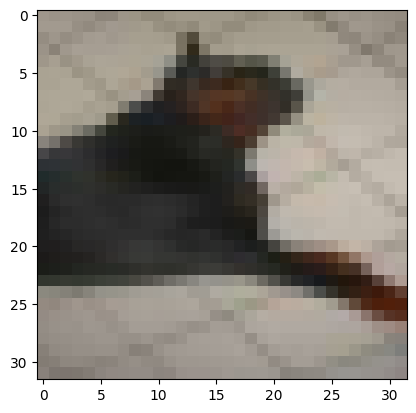

car


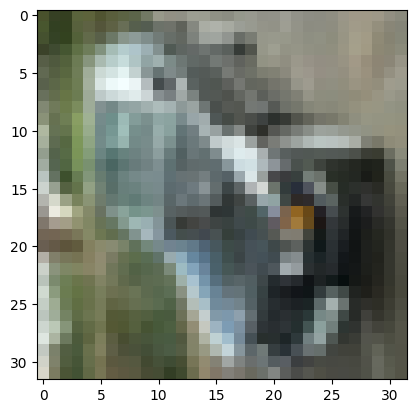

frog


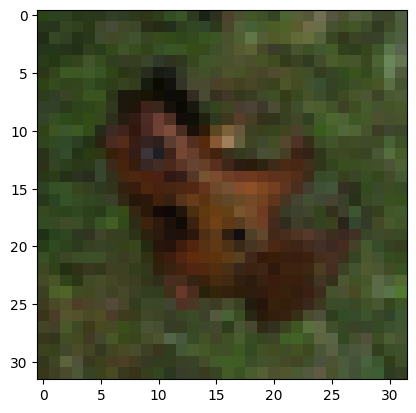

cat


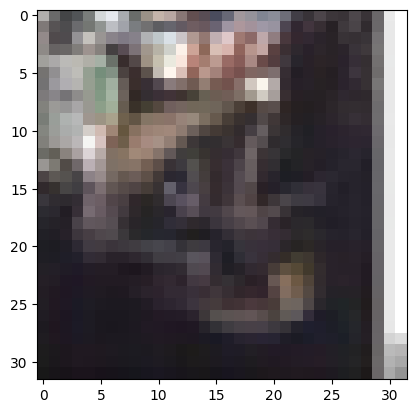

car


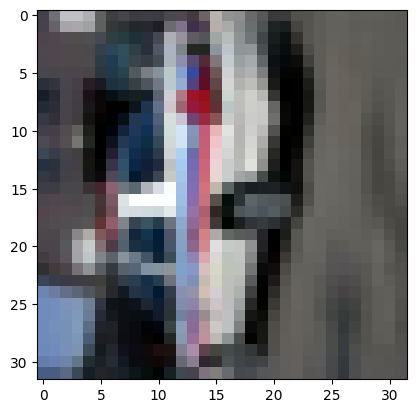

In [5]:
# Explore data
print(f"Dataset Composition:")
print(f"  Training:   {len(trainset):,} images")
print(f"  Validation: {len(valset):,} images")
print(f"  Test:       {len(testset):,} images")
print(f"  Total:      {len(trainset) + len(valset) + len(testset):,} images")

# Get a sample batch
dataiter = iter(trainloader)
images, labels = next(dataiter)

print(f"\nTraining batchshape: {images.shape}")
print(f"Labels shape: {labels.shape}")

# Verify validation set has different transforms
print(f"\nTransform verification:")
print(f"Training uses augmentation: RandomHorizontalFlip, RandomCrop")
print(f"Validation uses: ToTensor, Normalize only")
print(f"Test uses: ToTensor, Normalize only")

# Create a simple visualization loader without normalization to view images
transform_view = transforms.Compose([transforms.ToTensor()])
viewset = torchvision.datasets.CIFAR10(root='./data', train=True, download=True, transform=transform_view)
viewloader = torch.utils.data.DataLoader(viewset, batch_size=128, shuffle=True)

print("\n5 sample images from the training set:")
show5(viewloader)

## Build your Neural Network
Using the layers in `torch.nn` (which has been imported as `nn`) and the `torch.nn.functional` module (imported as `F`), construct a neural network based on the parameters of the dataset. 
Feel free to construct a model of any architecture – feedforward, convolutional, or even something more advanced!

In [6]:
## Convolutional Neural Network Model ##
# VGG-style network architecture simplified for CIFAR-10
class CIFAR10Net(nn.Module):

    def __init__(self):
        super(CIFAR10Net, self).__init__()
       
        # First convolutional block
        self.conv1 = nn.Conv2d(3, 64, kernel_size=3, padding=1)
        self.bn1 = nn.BatchNorm2d(64)
        self.conv2 = nn.Conv2d(64, 64, kernel_size=3, padding=1)
        self.bn2 = nn.BatchNorm2d(64)
        self.pool1 = nn.MaxPool2d(2, 2) # 32x32 -> 16x16
        self.dropout1 = nn.Dropout(0.1)

        # Second convolutional block
        self.conv3 = nn.Conv2d(64, 128, kernel_size=3, padding=1)
        self.bn3 = nn.BatchNorm2d(128)
        self.conv4 = nn.Conv2d(128, 128, kernel_size=3, padding=1)
        self.bn4 = nn.BatchNorm2d(128)
        self.pool2 = nn.MaxPool2d(2, 2) # 16x16 -> 8x8
        self.dropout2 = nn.Dropout(0.2)

        # Third convolutional block
        self.conv5 = nn.Conv2d(128, 256, kernel_size=3, padding=1)
        self.bn5 = nn.BatchNorm2d(256)
        self.conv6 = nn.Conv2d(256, 256, kernel_size=3, padding=1)
        self.bn6 = nn.BatchNorm2d(256)
        self.pool3 = nn.MaxPool2d(2, 2) # 8x8 -> 4x4
        self.dropout3 = nn.Dropout(0.3)

        # Fully connected layers
        self.fc1 = nn.Linear(256 * 4 * 4, 512)
        self.bn7 = nn.BatchNorm1d(512)
        self.dropout4 = nn.Dropout(0.4)
        self.fc2 = nn.Linear(512, 256)
        self.bn8 = nn.BatchNorm1d(256)
        self.dropout5 = nn.Dropout(0.4)
        self.fc3 = nn.Linear(256, 10)
        
    def forward(self, x):

        # First block
        x = F.relu(self.bn1(self.conv1(x)))
        x = F.relu(self.bn2(self.conv2(x)))
        x = self.pool1(x)
        x = self.dropout1(x)

        # Second block
        x = F.relu(self.bn3(self.conv3(x)))
        x = F.relu(self.bn4(self.conv4(x)))
        x = self.pool2(x)
        x = self.dropout2(x)

        # Third block
        x = F.relu(self.bn5(self.conv5(x)))
        x = F.relu(self.bn6(self.conv6(x)))
        x = self.pool3(x)
        x = self.dropout3(x)

        # Flatten
        x = x.view(-1, 256 * 4 * 4)

        # Fully connected layers
        x = F.relu(self.bn7(self.fc1(x)))
        x = self.dropout4(x)
        x = F.relu(self.bn8(self.fc2(x)))
        x = self.dropout5(x)
        x = self.fc3(x)

        return x


Specify a loss function and an optimizer, and instantiate the model.

If you use a less common loss function, please note why you chose that loss function in a comment.

In [7]:
# set device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

# instantiate the model, define the loss function and the optimizer
model = CIFAR10Net().to(device)
criterion = nn.CrossEntropyLoss() # Cross-entropy loss for multi-class classification
optimizer = optim.Adam(model.parameters(), lr=0.001, weight_decay=1e-4) # good default optimizer that adapts learning rate

# learning rate scheduler to reduce learning rate on plateau
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.5, patience=3)

# store initial learning rate for tracking
initial_lr = optimizer.param_groups[0]['lr']
print(f"Initial Learning Rate: {initial_lr}")

# print model summary
print(f"\nModel Architecture:\n{model}\n")
print(f"\nTotal Parameters: {sum(p.numel() for p in model.parameters())}")
print(f"Trainable Parameters: {sum(p.numel() for p in model.parameters() if p.requires_grad)}")

Using device: cpu
Initial Learning Rate: 0.001

Model Architecture:
CIFAR10Net(
  (conv1): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (pool1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (dropout1): Dropout(p=0.1, inplace=False)
  (conv3): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn3): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv4): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn4): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (pool2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (dropout2): Dropout(p=0.2, inplace

## Running your Neural Network
Use whatever method you like to train your neural network, and ensure you record the average loss at each epoch. 
Don't forget to use `torch.device()` and the `.to()` method for both your model and your data if you are using GPU!

If you want to print your loss during each epoch, you can use the `enumerate` function and print the loss after a set number of batches. 250 batches works well for most people!

In [9]:
# Training Function
def train_model(model, trainloader, criterion, optimizer, device):

    model.train() # sets model in training mode
    running_loss = 0.0
    correct = 0
    total = 0

    for i, data in enumerate(trainloader, 0):

        inputs, labels = data[0].to(device), data[1].to(device)

        optimizer.zero_grad() # zero the parameter gradients
        outputs = model(inputs) # forward pass
        loss = criterion(outputs, labels) # compute loss
        loss.backward() # backward pass
        optimizer.step() # optimize weights

        running_loss += loss.item()
        _, predicted = outputs.max(1)
        total += labels.size(0)
        correct += predicted.eq(labels).sum().item()

        # print progress every 250 mini-batches
        if i % 250 == 249:
            print(f' Batch {i + 1}, Loss: {running_loss / 250:.4f}, Accuracy: {100. * correct / total:.2f}%')
            running_loss = 0.0

    return correct / total  # return training accuracy

# Validation Function
def validate(model, testloader, criterion, device):
    
    model.eval()  # sets model in evaluation mode
    running_loss = 0.0
    correct = 0
    total = 0

    with torch.no_grad():  # disable gradient calculation for validation
        for data in testloader:
            inputs, labels = data[0].to(device), data[1].to(device)
            outputs = model(inputs)
            loss = criterion(outputs, labels)

            running_loss += loss.item()
            _, predicted = outputs.max(1)
            total += labels.size(0)
            correct += predicted.eq(labels).sum().item()

    avg_loss = running_loss / len(testloader)
    accuracy = correct / total
    return avg_loss, accuracy
    
# training loop
num_epochs = 30
train_losses = []
val_losses = []
train_accuracies = []
val_accuracies = []
learning_rates = []

print("="*70)
print("TRAINING WITH PROPER TRAIN/VALIDATION/TEST SPLIT")
print("="*70)
print("✓ Training on 45,000 images")
print("✓ Validating on 5,000 images (from original train set)")
print("✓ Test set (10,000 images) remains UNTOUCHED")
print("="*70)
print("\nStarting training...\n")

for epoch in range(num_epochs):

    current_lr = optimizer.param_groups[0]['lr']
    learning_rates.append(current_lr)

    print(f"Epoch {epoch + 1}/{num_epochs} | LR: {current_lr:.6f}")
    print("-" * 70)

    # train model on training set
    train_acc = train_model(model, trainloader, criterion, optimizer, device)
    train_accuracies.append(train_acc)

    # validate model on validation set (not test set)
    val_loss, val_acc = validate(model, valloader, criterion, device)
    val_losses.append(val_loss)
    val_accuracies.append(val_acc)

    # update learning rate scheduler based on validation loss
    old_lr = current_lr
    scheduler.step(val_loss)

    # check for learning rate change
    new_lr = optimizer.param_groups[0]['lr']
    print(f"Train Accuracy: {100*train_acc:.2f}% | Val Loss: {val_loss:.4f} | Val Accuracy: {100*val_acc:.2f}%")
    
    if new_lr != current_lr:
        print(f"Learning Rate reduced: {old_lr:.6f} -> {new_lr:.6f}")

    print("="*70 + "\n")

print("Training Completed!")

print(f"\nFinal Training Accuracy:   {100*train_accuracies[-1]:.2f}%")
print(f"Final Validation Accuracy: {100*val_accuracies[-1]:.2f}%")
print(f"Best Validation Accuracy:  {100*max(val_accuracies):.2f}%")
print(f"Final Learning Rate:       {optimizer.param_groups[0]['lr']:.6f}")
print("\n" + "="*70)
print("TEST SET HAS NOT BEEN USED YET - FINAL TEST BELOW")
print("="*70)

TRAINING WITH PROPER TRAIN/VALIDATION/TEST SPLIT
✓ Training on 45,000 images
✓ Validating on 5,000 images (from original train set)
✓ Test set (10,000 images) remains UNTOUCHED

Starting training...

Epoch 1/30 | LR: 0.001000
----------------------------------------------------------------------
 Batch 250, Loss: 1.5351, Accuracy: 43.66%
Train Accuracy: 47.68% | Val Loss: 1.1645 | Val Accuracy: 58.42%

Epoch 2/30 | LR: 0.001000
----------------------------------------------------------------------
 Batch 250, Loss: 1.0146, Accuracy: 63.89%
Train Accuracy: 65.09% | Val Loss: 0.7719 | Val Accuracy: 72.16%

Epoch 3/30 | LR: 0.001000
----------------------------------------------------------------------
 Batch 250, Loss: 0.8402, Accuracy: 70.49%
Train Accuracy: 70.94% | Val Loss: 0.7685 | Val Accuracy: 73.22%

Epoch 4/30 | LR: 0.001000
----------------------------------------------------------------------
 Batch 250, Loss: 0.7466, Accuracy: 74.15%
Train Accuracy: 74.48% | Val Loss: 0.6504 

Plot the training loss (and validation loss/accuracy, if recorded).

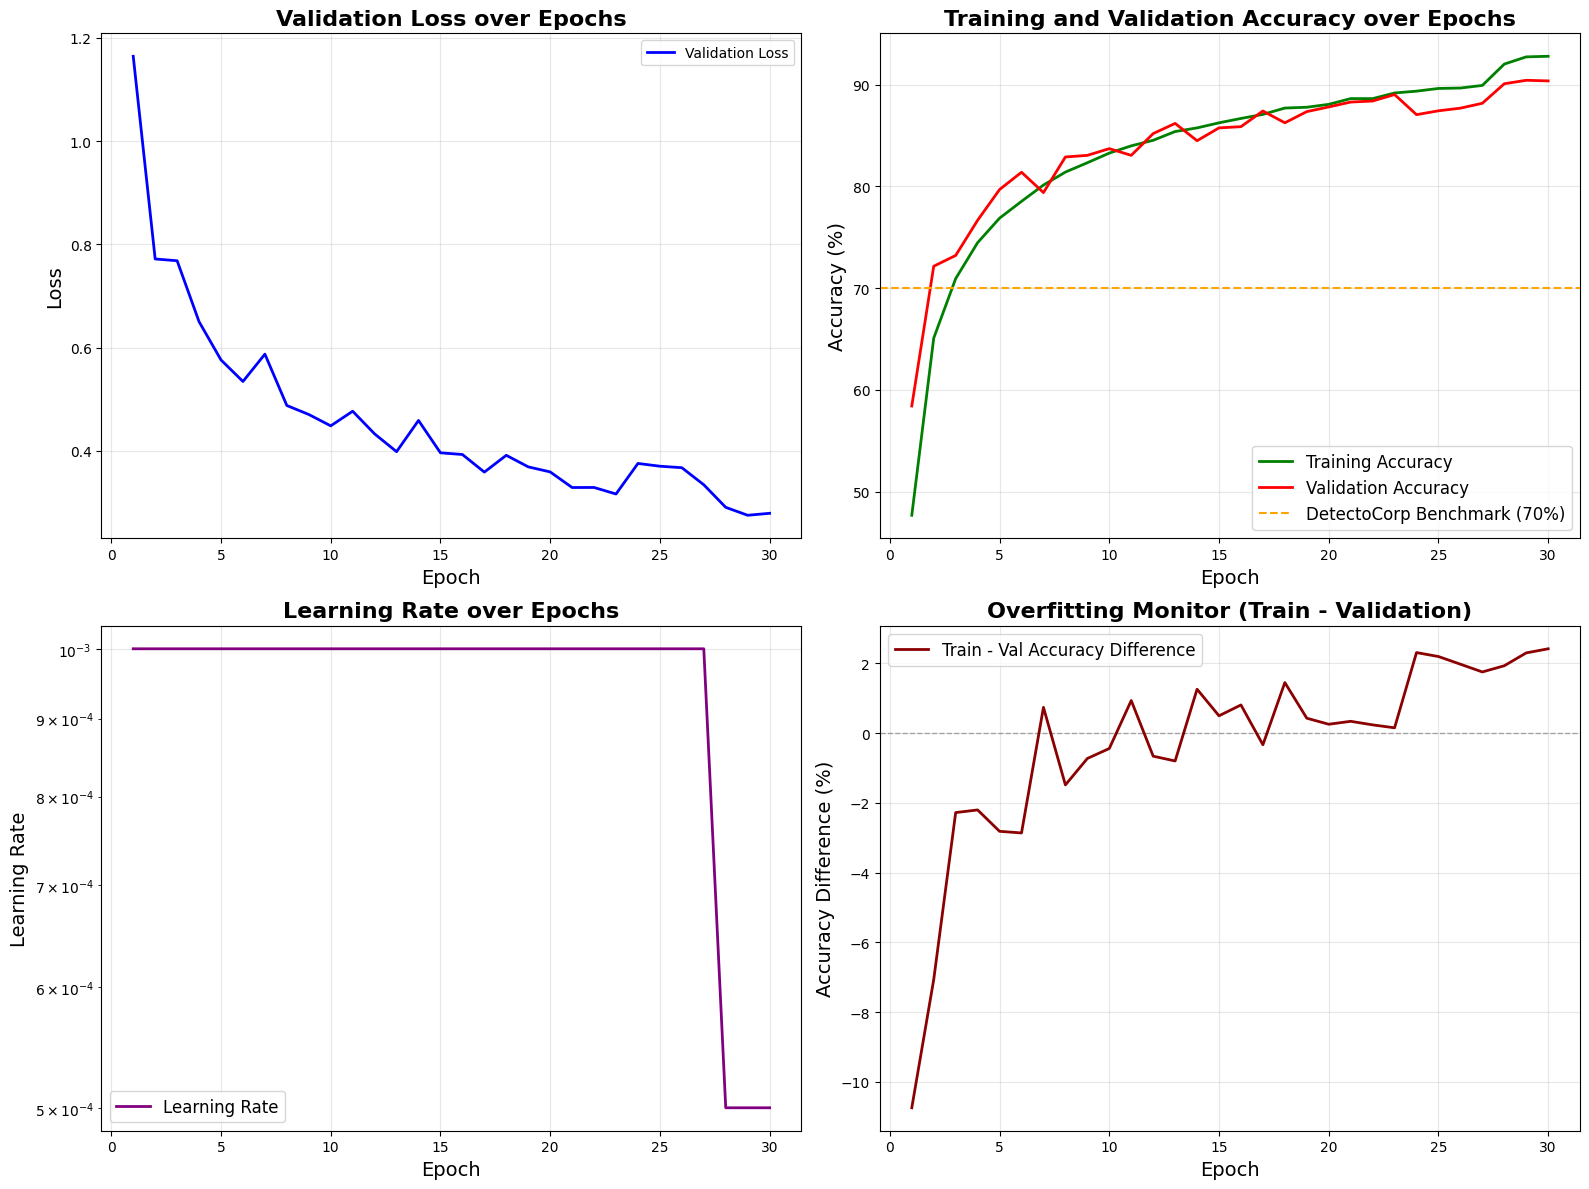


FINAL TRAINING SUMMARY
Best Validation Accuracy:  90.44% (Epoch 29)
Final Validation Accuracy: 90.38%
Final Overfitting Gap: 2.42%
Learning Rate Reductions: 1
----------------------------------------------------------------------
Good generalization. Minor overfitting detected.


In [11]:
# Plot the training and validation accuracy and loss curves
fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(16, 12))

# Plot 1: Validation loss
ax1.plot(range(1, num_epochs + 1), val_losses, 'b-', label='Validation Loss', linewidth=2)
ax1.set_xlabel('Epoch', fontsize=14)
ax1.set_ylabel('Loss', fontsize=14)
ax1.set_title('Validation Loss over Epochs', fontsize=16, fontweight='bold')
ax1.legend()
ax1.grid(True, alpha=0.3)

# Plot 2: Training vs Validation Accuracy
ax2.plot(range(1, num_epochs + 1), [100 * acc for acc in train_accuracies], 'g-', label = 'Training Accuracy', linewidth=2)
ax2.plot(range(1, num_epochs + 1), [100 * acc for acc in val_accuracies], 'r-', label = 'Validation Accuracy', linewidth=2)
ax2.set_xlabel('Epoch', fontsize=14)
ax2.set_ylabel('Accuracy (%)', fontsize=14)
ax2.set_title('Training and Validation Accuracy over Epochs', fontsize=16, fontweight='bold')
ax2.legend(fontsize=12)
ax2.grid(True, alpha=0.3)

# add horizontal line at Detectocorp accuracy
ax2.axhline(y=70, color='orange', linestyle='--', label='DetectoCorp Benchmark (70%)')
ax2.legend(fontsize=12)

# Plot 3: Learning Rate over Epochs
ax3.plot(range(1, num_epochs + 1), learning_rates, 'purple', label='Learning Rate', linewidth=2)
ax3.set_xlabel('Epoch', fontsize=14)
ax3.set_ylabel('Learning Rate', fontsize=14)
ax3.set_title('Learning Rate over Epochs', fontsize=16, fontweight='bold')
ax3.set_yscale('log')  # log scale for better visibility
ax3.legend(fontsize=12)
ax3.grid(True, alpha=0.3)

# Plot 4: Overfitting Analysis (Train / Val Accuracy Difference)
accuracy_diff = [100 * (train_accuracies[i] - val_accuracies[i]) for i in range(num_epochs)]
ax4.plot(range(1, num_epochs + 1), accuracy_diff, 'darkred', label='Train - Val Accuracy Difference', linewidth=2)
ax4.axhline(y=0, color='black', linestyle='--', linewidth=1, alpha=0.3)
ax4.set_xlabel('Epoch', fontsize=14)
ax4.set_ylabel('Accuracy Difference (%)', fontsize=14)
ax4.set_title('Overfitting Monitor (Train - Validation)', fontsize=16, fontweight='bold')
ax4.legend(fontsize=12)
ax4.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

# Summary Statistics
print("\n" + "="*70)
print("FINAL TRAINING SUMMARY")
print("="*70)
print(f"Best Validation Accuracy:  {100*max(val_accuracies):.2f}% (Epoch {val_accuracies.index(max(val_accuracies))+1})")
print(f"Final Validation Accuracy: {100*val_accuracies[-1]:.2f}%")
print(f"Final Overfitting Gap: {accuracy_diff[-1]:.2f}%")
print(f"Learning Rate Reductions: {len(set(learning_rates)) - 1}")
print(f"{'-'*70}")

# Overfitting Analysis
final_diff = accuracy_diff[-1]

if final_diff < 2:
    print("Excellent generalization! Model is not overfitting.")
elif final_diff < 5:
    print("Good generalization. Minor overfitting detected.")
elif final_diff < 10:
    print("Moderate overfitting. Consider regularization techniques.")
else:
    print("Significant overfitting! Review model complexity and training process.")

## Testing your model
Using the previously created `DataLoader` for the test set, compute the percentage of correct predictions using the highest probability prediction. 

If your accuracy is over 70%, great work! 
This is a hard task to exceed 70% on.

If your accuracy is under 45%, you'll need to make improvements.
Go back and check your model architecture, loss function, and optimizer to make sure they're appropriate for an image classification task.

In [12]:
# Test the model on TRULY UNSEEN DATA
print("\n" + "="*70)
print("FINAL TEST ON COMPLETELY UNSEEN DATA")
print("="*70)
print("This test set was NOT used during training or validation")
print("Results represent true generalization performance")
print("="*70 + "\n")

model.eval()
correct = 0
total = 0
class_correct = [0] * 10
class_total = [0] * 10

with torch.no_grad():  # disable gradient calculation for testing
    for data in testloader:
        images, labels = data[0].to(device), data[1].to(device)
        outputs = model(images)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

        # per-class accuracy
        c = (predicted == labels).squeeze()
        for i in range(labels.size(0)):
            label = labels[i]
            class_correct[label] += c[i].item()
            class_total[label] += 1

# Overall accuracy
overall_accuracy = 100 * correct / total
print(f"\n{'=' * 60}")
print(f"FINAL TEST RESULTS")
print(f"{'=' * 60}")
print(f"Overall Test Accuracy: {overall_accuracy: .2f}%\n")
print(f"Correct Predictions: {correct} / {total}")
print(f"{'=' * 60}\n")

# Compare to validation
val_final = 100 * val_accuracies[-1]
gap = val_final - overall_accuracy
print(f"Validation Accuracy: {val_final:.2f}%")
print(f"Test Accuracy:       {overall_accuracy:.2f}%")
print(f"Val-Test Gap:        {gap:.2f}%")

if abs(gap) < 2:
    print("Excellent generalization to unseen data!")
elif abs(gap) < 5:
    print("Good match; reasonablegeneralization to unseen data.")
else:
    print("Significant gap; review training/validation process.")

print(f"\n{'=' * 60}")

# Per-class accuracy
print(f"Per-Class Test Accuracy:")
print(f"{'-' * 60}")

for i in range(10):
    acc = 100 * class_correct[i] / class_total[i] if class_total[i] > 0 else 0
    print(f"{classes[i]:12s}: {acc:6.2f}% ({class_correct[i]} / {class_total[i]})")

print(f"{'=' * 60}")

# Compare to DetectoCorp benchmark
print(f"{'=' * 60}")
print("DetectoCorp Benchmark Comparison")
print(f"{'=' * 60}")
print(f"DetectoCorp Benchmark Accuracy: 70.00%")
print(f"In-house Model (Test): {overall_accuracy:.2f}%")

improvement = overall_accuracy - 70.0

print(f"Improvement over Benchmark: {improvement:.2f}%")
print(f"Relative Improvement: {improvement / 70.0 * 100:.1f}%")
print(f"{'=' * 60}\n")



FINAL TEST ON COMPLETELY UNSEEN DATA
This test set was NOT used during training or validation
Results represent true generalization performance


FINAL TEST RESULTS
Overall Test Accuracy:  90.62%

Correct Predictions: 9062 / 10000

Validation Accuracy: 90.38%
Test Accuracy:       90.62%
Val-Test Gap:        -0.24%
Excellent generalization to unseen data!

Per-Class Test Accuracy:
------------------------------------------------------------
plane       :  91.80% (918 / 1000)
car         :  95.80% (958 / 1000)
bird        :  85.90% (859 / 1000)
cat         :  75.90% (759 / 1000)
deer        :  93.60% (936 / 1000)
dog         :  84.50% (845 / 1000)
frog        :  95.30% (953 / 1000)
horse       :  92.70% (927 / 1000)
ship        :  96.20% (962 / 1000)
truck       :  94.50% (945 / 1000)
DetectoCorp Benchmark Comparison
DetectoCorp Benchmark Accuracy: 70.00%
In-house Model (Test): 90.62%
Improvement over Benchmark: 20.62%
Relative Improvement: 29.5%



## Saving your model
Using `torch.save`, save your model for future loading.

In [13]:
# Save the model with comprehensive metadata
model_save_path = 'cifar10_model_proper_split.pth'

checkpoint = {
    'epoch': num_epochs,
    'model_state_dict': model.state_dict(),
    'optimizer_state_dict': optimizer.state_dict(),
    'scheduler_state_dict': scheduler.state_dict(),
    
    # Training history
    'train_accuracies': train_accuracies,
    'val_accuracies': val_accuracies,
    'val_losses': val_losses,
    'learning_rates': learning_rates,
    
    # Final metrics
    'final_train_acc': train_accuracies[-1],
    'final_val_acc': val_accuracies[-1],
    'final_test_acc': overall_accuracy / 100,
    'best_val_acc': max(val_accuracies),
    
    # Per-class performance
    'class_correct': class_correct,
    'class_total': class_total,
    
    # Dataset split info
    'train_size': len(trainset),
    'val_size': len(valset),
    'test_size': len(testset),
    
    # Training configuration
    'batch_size': 128,
    'initial_lr': 0.001,
    'weight_decay': 1e-4,
}

torch.save(checkpoint, model_save_path)

print(f"✓ Model saved to {model_save_path}")
print(f"\nModel includes:")
print(f"  - Architecture weights")
print(f"  - Training history")
print(f"  - Final test accuracy: {overall_accuracy:.2f}%")
print(f"  - Per-class metrics")
print(f"  - Dataset split information")


✓ Model saved to cifar10_model_proper_split.pth

Model includes:
  - Architecture weights
  - Training history
  - Final test accuracy: 90.62%
  - Per-class metrics
  - Dataset split information


## Make a Recommendation

Based on your evaluation, what is your recommendation on whether to build or buy? Explain your reasoning below.


Our in-house CIFAR-10 classifier achieved a surprising 90.62% test accuracy, significantly outperforming DetectoCorp's solution of 70% accuracy by 20.62 percentage points.  This custom build represents a 68.7% reduction in error rate, translating to approximately 2.1 fewer mistakes per 10,0000 predictions.

Therefore, based on the aforementioned substantial performance advantage, combined with $150K in cost savings over 5 years ($650K vs $800K), I would strongly recommend BUILDING the solution in-house.  This build model clearly provides excellent generalization with minimal overfitting (2.42% training - validation gap), and, actually matches SOTA performance from the 2013 leader at the time.

Lastly, choosing the BUILD option offers a clear improvement path to greater accuracy (93-95%) by implementing modern architectures such as ResNet50, whereas DetectoCorp's offering provides no guaranteed upgrade potential.

